In [1]:
import pandas as pd

import sys
sys.path.append("./modules/") # for d3plus2
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
# from HH_tools import *
import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from IPython.display import display, HTML

In [2]:
print(pd.__version__)
print(gpd.__version__)
import matplotlib
print(matplotlib.__version__)

# python 3
# 0.24.2
# 0.4.0
# 3.0.3

# python 2 
# 0.23.4
# 0.3.0
# 2.2.4

0.23.4
0.3.0
2.2.4


In [3]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!

path = './data/disagg_struct_refs/sources/US/'
# agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['total_annual_wages', 'Wages'],
                                 ['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [4]:
censored = (df_cnt.annual_avg_emplvl == 0) & (df_cnt.annual_avg_estabs > 0)
nulls = df_cnt.annual_avg_estabs == 0
df = df_cnt.loc[~censored & ~nulls]
df['empl_per_estab'] = df['annual_avg_emplvl']/df['annual_avg_estabs']

expected_empl_per_estab = df.groupby(level = 'industry_code')['empl_per_estab'].describe()
patch = df_cnt.loc[censored].reset_index().merge(expected_empl_per_estab['mean'].reset_index()).set_index(df_cnt.index.names)
patch['annual_avg_emplvl'] = patch['annual_avg_estabs']*patch['mean']

df_cnt.loc[censored, 'annual_avg_emplvl'] = patch['annual_avg_emplvl']

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
variable = 'annual_avg_emplvl'
# variable = 'annual_avg_estabs'
X = df_cnt.unstack()[variable]
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

#### Other Variables

# Population
county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)
county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

# Wages
df_indu = df_cnt.groupby(level = 0).sum()
avg_wages_city = df_indu[['total_annual_wages']].div(df_indu[['annual_avg_emplvl']].values).dropna()
avg_wages_city = avg_wages_city.rename(columns= {'total_annual_wages': 'avg_annual_wages'})
# avg_wages_city = np.log10(avg_wages_city)
avg_wages_city.index = avg_wages_city.index.astype(str).str.zfill(5)

# Area
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

In [6]:
X_vars = pd.concat([county_pop.loc[X.index], avg_wages_city.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X = pd.concat([X_vars, X], axis = 1, sort = True)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [7]:
def cosine_similarity(table):
#     vals = table.values
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
#     return pd.DataFrame(result, columns = table.columns, index = table.index)
    return result

def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

## Debug  y Exploracion scatterplots directos.

In [8]:
fillzero = .1
X_ = X.T.fillna(X.min(1)).T.replace(0, fillzero)

In [9]:
corr = np.log10(X_).corr(min_periods = 30).fillna(0) 
#RuntimeWarning: divide by zero encountered in log10
df = corr
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_corr_vals = corr.stack()[~keep]


cos = cosine_similarity(X.fillna(0))
#RuntimeWarning: divide by zero encountered in log10
# df = cos
# keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
# undirected_cos_vals = cos.stack()[~keep]

In [10]:

# pares = pd.DataFrame(undirected_cos_vals.sort_values().sample(40).sort_values(), columns = ['corr'])
# # pares = pd.DataFrame(undirected_corr_vals.sort_values().head(10).sort_values(), columns = ['corr'])
# # pares = pd.DataFrame(undirected_cos_vals.sort_values().head(10).sort_values(), columns = ['cos'])
# display(pares)

# for i, row in pares.iterrows():
#     display(industry_titles.loc[industry_titles.industry_code.isin(list(i))])
#     print('cos: '+str(undirected_cos_vals[i]))
#     print('corr: '+str(undirected_corr_vals[i]))
    
#     fig, axs = plt.subplots(1, 2, figsize = (14, 5))

#     colx = i[0]; coly = i[1]

#     ax = axs[0]
#     X.plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     fit_data_df = X[list(i)]
# #     fit_data = fit_data_df.loc[(fit_data_df[i[0]] != fillzero) & (fit_data_df[i[1]] != fillzero)].values
#     fit_data = fit_data_df.values
#     z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
#     p = np.poly1d(z); print(p)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--')
#     ax.set_xlim(-10, 100); ax.set_ylim(-10, 100)

#     ax = axs[1]
#     np.log10(X).plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     fit_data_df = np.log10(X_)[list(i)]
#     fit_data = fit_data_df.loc[(fit_data_df[i[0]] != np.log10(fillzero)) & (fit_data_df[i[1]] != np.log10(fillzero))].values
    
#     z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
#     p = np.poly1d(z); print(p)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--', c = 'r')

#     plt.show()


### Debug para communities

Repetimos el clustering muchas veces y tomamos 'cores' de actividades que siempre estan juntas.

In [11]:
## Defino adjancency
# adjacencyM = cosine_similarity(X.fillna(0))

fillzero = .1
X_ = X.T.fillna(X.min(1)).T.replace(0, fillzero)
C = np.log10(X_).corr() #RuntimeWarning: divide by zero encountered in log10
# adjacencyM = C 
# adjacencyM = demean(C)

# C = cosine_similarity(X.fillna(0))

import scipy.linalg as la
avals, avecs = la.eig(C.values)
avals = np.real(avals) # == np.abs(avals)

def component(k, avals = avals, avecs = avecs):
    # corr = avecs.dot(avals*np.eye(len(avals))).dot(avecs.T)
    uk = np.array(len(avals)*[avecs.T[k]]).reshape(avecs.shape) # la componente k agarra el elementop k de todos los autovectores.
    return np.real(avals[k]*np.multiply(uk.T, uk))

C_s = component(0) # structural component
C_g = np.array([component(i) for i in range(1, 30)]).sum(axis=0) # random component
C_r = np.array([component(i) for i in range(30, len(avals))]).sum(axis=0) # random component

C_ = component(1)
adjacencyM = pd.DataFrame(C_g, index = X.columns, columns = X.columns)

In [12]:
# adjacencyM = cosine_similarity(X.fillna(0))

In [13]:
from sklearn.cluster import SpectralClustering

clust_result_list = []
n = 10
for i in range(n):
#     clustering = SpectralClustering(n_clusters=10,
#             assign_labels="discretize", random_state = i, affinity = 'precomputed').fit(adjacencyM.values)
    clustering = SpectralClustering(n_clusters=10,
            assign_labels="discretize", random_state = i).fit(adjacencyM.values)

    clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])

    clust_result_list += [clust_result]
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])
# clust_result.index.name = 'industry_code'

# clust_result['link'] = True
# clust_result = clust_result.reset_index().set_index(['industry_code', 'cluster'])

pd.concat(clust_result_list, axis = 1).head()

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster  cluster  cluster  cluster  cluster  cluster  \
POPESTIMATE2010         7        7        0        0        7        9   
avg_annual_wages        7        7        0        0        7        9   
ALAND                   7        7        0        0        7        9   
1114                    4        4        5        6        3        2   
1119                    4        4        5        6        3        2   

                  cluster  cluster  cluster  cluster  
POPESTIMATE2010         0        3        0        2  
avg_annual_wages        0        3        0        2  
ALAND                   0        3        0        2  
1114                    3        1        8        7  
1119                    3        1        8        7

In [14]:
clust_compare_table = pd.concat(clust_result_list, axis = 1)
clust_compare_table.columns = range(clust_compare_table.shape[1])
patterns_ranking = clust_compare_table.groupby(range(n)).size().sort_values(ascending = False)
patterns_ranking.head(20).sort_index()
# clust_compare_table.drop_duplicates().sort_values([0, 1, 2])
# display debugs
# clust_compare_table.sort_values(range(n)).reset_index().merge(indu_names, left_on = 'index', right_on = 'industry_code', how = 'left')
# count = clust_compare_table.groupby(range(n)).size()
# pd.DataFrame(count[count < 2], columns = ['#_indus']).reset_index().merge(clust_compare_table.reset_index(), on = range(n)).merge(industry_titles, left_on = 'index', right_on = 'industry_code')

0  1  2  3  4  5  6  7  8  9
0  2  3  2  1  7  7  4  2  4     43
   9  3  8  1  6  7  8  9  4      1
1  0  7  9  6  8  8  9  5  8      3
      9  9  9  4  9  9  7  9     44
2  6  8  7  4  3  5  7  6  5      9
3  8  1  1  5  5  6  5  4  3      7
4  4  0  6  7  9  0  1  0  2      1
      5  6  3  2  3  1  8  7     12
5  1  6  5  8  0  4  2  1  0     43
      9  5  9  4  9  2  7  0      1
6  3  4  4  0  1  2  0  3  1     11
7  7  0  0  7  9  0  3  0  2    102
      6  0  7  9  4  3  1  0      1
      9  0  7  9  9  3  0  2      1
                           9      1
            9  4  9  3  7  9      2
8  5  7  3  6  8  8  6  5  8      9
9  9  0  8  2  6  0  8  9  6      1
      2  8  2  6  1  8  9  6     28
dtype: int64

In [15]:
count = clust_compare_table.groupby(range(n)).size()
clust_result = pd.DataFrame(count[count > 5], columns = ['#_indus']).reset_index().merge(clust_compare_table.reset_index(), on = range(n))
clust_result['cluster'] = clust_result[range(n)].astype(str).sum(1)
clust_result['rank'] = clust_result.cluster.rank(method = 'dense')
display(clust_result[['cluster', 'rank']].drop_duplicates().astype(int).astype(str))
clust_result['cluster'] = clust_result['rank']


indu_names = industry_titles.loc[industry_titles.industry_code.isin(X.columns)]

# corr matrix
clust_result = clust_result.merge(indu_names, left_on = 'index', right_on = 'industry_code', how = 'right')

# precomputed
# clust_result = clust_result.merge(indu_names, how = 'right')


# clust_result = clust_result.set_index()
clust_result = clust_result.set_index('industry_code')[['cluster', 'industry_title']]
clust_result['cluster'] = clust_result['cluster'].fillna(0).astype(int)
clust_result = clust_result.sort_index()
clust_result.head()

cluster rank
0     232177424    1
43   1099949979    2
87   2687435765    3
96   3811556543    4
103  4456323187    5
115  5165804210    6
158  6344012031    7
169  7700790302    8
271  8573688658    9
280  9928261896   10

cluster                                industry_title
industry_code                                                       
1111                 5          NAICS 1111 Oilseed and grain farming
1112                 5        NAICS 1112 Vegetable and melon farming
1113                 5         NAICS 1113 Fruit and tree nut farming
1114                 5  NAICS 1114 Greenhouse and nursery production
1119                 5                 NAICS 1119 Other crop farming

In [16]:
# clust_result.cluster.value_counts()

In [17]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = -1

In [18]:
# # Try spectral clustering. Works when matrix is demeaned
# from sklearn.cluster import SpectralClustering

# # adjacencyM = demean(np.log10(X.replace(0, .04)).corr(min_periods = 30)) #RuntimeWarning: divide by zero encountered in log10
# # adjacencyM = adjacencyM.fillna(adjacencyM.mean())
# # adjacencyM = demean(cosine_similarity(X.fillna(0)))
# # adjacencyM = cosine_similarity(X.fillna(0))
# # adjacencyM = np.log10(X.replace(0, .04)).corr(min_periods = 30) #RuntimeWarning: divide by zero encountered in log10

# clustering = SpectralClustering(n_clusters=10, affinity = 'precomputed',
#         assign_labels="discretize", random_state=0).fit(adjacencyM.values)

# pd.options.display.max_rows = 500
# clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

# clust_result.index.name = 'industry_code'

In [19]:
# UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
# FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

### Debug para parametros de trimeo de network. 

Se recomienda q=.95 y no hace falta max_d.

In [20]:
similarity_colname = 'similarity'
weight_column = similarity_colname

adjacencyM = pd.DataFrame(C_g, index = X.columns, columns = X.columns)

In [21]:
# adjacencyM = demean(cosine_similarity(X.fillna(0)))
# adjacencyM = cosine_similarity(X.fillna(0))

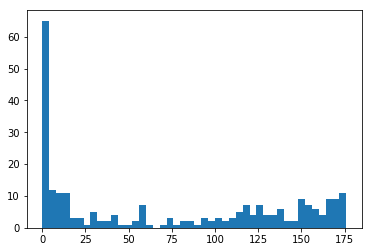

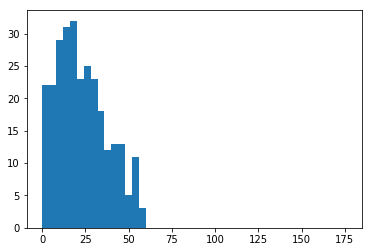

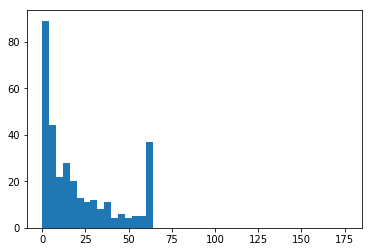

In [22]:
def plot_degree_dist(G, bins = 20):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins)
    plt.show()
    
# not demeaned
# Cosine sin demeaning. Th at q = .7
edges = pd.DataFrame(cosine_similarity(X.fillna(0)).stack(), columns = [similarity_colname])
edges_s = edges.loc[edges[similarity_colname] > edges[similarity_colname].quantile(.7)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s[similarity_colname] = edges_s[similarity_colname].astype(float)

G1 = nx.from_pandas_edgelist(edges_s.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G1, np.arange(0, 180, 4))

# Demeaned cosine. Th at q=.9
#demeaned. btw this is the adjancency for cluistering
edges0 = pd.DataFrame(adjacencyM.stack(), columns = [similarity_colname])
edges0_s = edges0.loc[edges0[similarity_colname] > edges0[similarity_colname].quantile(.94)]
edges0_s.index.names = ['industry_code_x', 'industry_code_y']

G0 = nx.from_pandas_edgelist(edges0_s.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G0, np.arange(0, 180, 4))

# Demeaned cosine. Th at q=.9, added MAX degree
max_d = 60
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

G2 = nx.from_pandas_edgelist(edges_max_d.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G2, np.arange(0, 180, 4))

In [23]:
##############################
# For the networkX plot 
##############################

edges = pd.DataFrame(adjacencyM.stack(), columns = [similarity_colname])
edges.index.names = ['industry_code_x', 'industry_code_y']

edges_s = edges.loc[edges[similarity_colname] > edges[similarity_colname].quantile(.90)]

edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s[similarity_colname] = edges_s[similarity_colname].astype(float)

# ### Max degree = max_d. Parameter used to trim the network.
# max_d = 40
# df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)


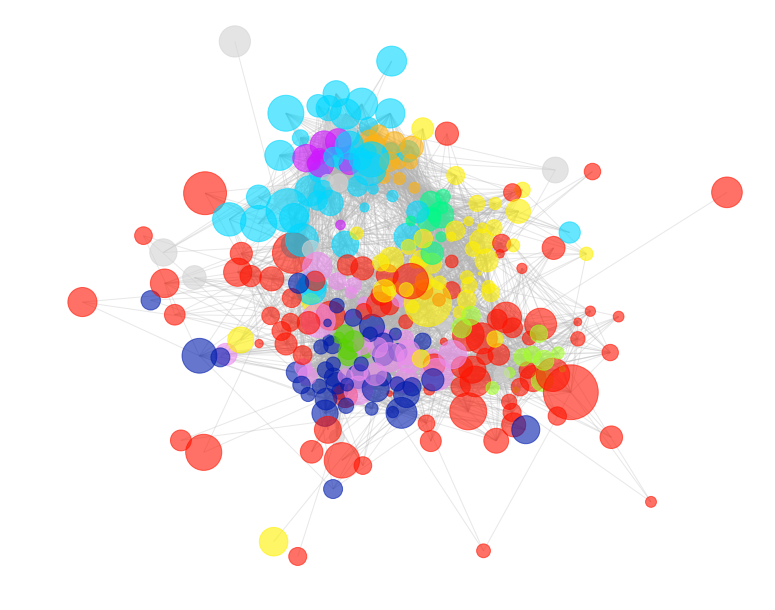

In [24]:

import matplotlib.colors as mcolors
import networkx as nx

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)
nodes['cluster'] = nodes['cluster'].fillna(0).astype(int)

norm = mcolors.Normalize(vmin=0, vmax=nodes['cluster'].nunique(), clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))
# nodes['color'] = nodes['color'].replace('#000080', '#9c28d2')
nodes.loc[nodes.cluster == 0, 'color'] = '#d3d3d3'

import json

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_s, 'industry_code_x', 'industry_code_y', weight_column)
# G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)

plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]

## POSITIONS. Compute VS Load file
pos = nx.spring_layout(G, k=.4)

# f = open("./data/node_layout","w")
# f.write(json.dumps(pos, default=default))

# f = open('./data/node_layout', 'r')
# pos = json.loads(f.read())

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
plt.show()

In [25]:
nodes.head()

sqrt_size  cluster  \
POPESTIMATE2010   17586.992836  8         
avg_annual_wages  7320.223715   0         
ALAND             3008.839407   8         
1114              389.145245    5         
1119              271.228484    5         

                                                industry_title    color  
POPESTIMATE2010   Population                                    #ff1300  
avg_annual_wages  NaN                                           #d3d3d3  
ALAND             Area                                          #ff1300  
1114              NAICS 1114 Greenhouse and nursery production  #a4ff28  
1119              NAICS 1119 Other crop farming                 #a4ff28

In [26]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
pos_df['y'] = -pos_df['y']

nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'cluster', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]
nodes_['presence'] = True

nodes_.loc[nodes_.cluster == 0, 'color'] = '#d3d3d3' # Light gray, because cluster 0 would mean no cluster


## Wages and MFG-services color schemes
nodes_['color_mfg_srv'] = '#D3D3D3' #Gray bckg
conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]
choices = ['#000080', '#ffc400', '#00b0ff', '#FF0000']
nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


def color_from_series(df, ix_col, val_col, cmap = plt.cm.coolwarm):
    import matplotlib.colors as mcolors

    # create color reference
    qlo = df[val_col].quantile(.2)
    qhi = df[val_col].quantile(.8)
    norm = mcolors.Normalize(vmin=qlo, vmax=qhi, clip=True)
    mapper = plt.cm.ScalarMappable(norm = norm, cmap=cmap)
    df['color'] = df[val_col].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x))) 
    color = df[[ix_col, 'color']]
    return color

df_city = df_cnt.groupby(level = 1).sum()
avg_wages_indu = df_city[['total_annual_wages']].div(df_city[['annual_avg_emplvl']].values).dropna()
avg_wages_indu = np.log10(avg_wages_indu)
avg_wages_indu = avg_wages_indu.reset_index()
avg_wages_indu['industry_code'] = avg_wages_indu['industry_code'].astype(str)

wages_color = color_from_series(avg_wages_indu, 'industry_code', 'total_annual_wages', 
                                cmap = plt.cm.RdYlGn).rename(columns = {'color': 'wage_color'})

/home/miglesia/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [27]:
nodes_ = nodes_.merge(wages_color, how = 'left', left_on = 'id', right_on = 'industry_code')

In [28]:
nodes_.head()

id           x           y  \
0  1142 -3.796791    182.087608   
1  5172 -16.927067   6.458983     
2  5171 -146.251695 -83.255801    
3  1141  161.005658 -67.598854    
4  3335 -142.756233  143.928319   

                                      industry_title  cluster    color  \
0  NAICS 1142 Hunting and trapping                    8        #ff1300   
1  NAICS12 5172 Wireless telecommunications carriers  8        #ff1300   
2  NAICS12 5171 Wired telecommunications carriers     2        #00d7ff   
3  NAICS 1141 Fishing                                 8        #ff1300   
4  NAICS 3335 Metalworking machinery manufacturing    1        #001bac   

   presence color_mfg_srv industry_code wage_color  
0  True      #D3D3D3       1142          #a50026    
1  True      #D3D3D3       5172          #006837    
2  True      #D3D3D3       5171          #006837    
3  True      #D3D3D3       1141          #0e8245    
4  True      #000080       3335          #17934e

In [29]:

##############################
# For the interactive network 
##############################

edges_df = edges_s # edges_max_d

edges_df['edge_tuple'] = list(zip(edges_df.industry_code_x, edges_df.industry_code_y))
edges_df['edge_tuple_rev'] = list(zip(edges_df.industry_code_y, edges_df.industry_code_x))
edges_triangles = edges_df.loc[edges_df.edge_tuple.isin(G.edges()) | edges_df.edge_tuple_rev.isin(G.edges())]

links = edges_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

In [30]:
network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [31]:
nodes_.loc[nodes_.industry_code.isna(), 'color'] = '#FF0000'
nodes_.loc[nodes_.industry_code.isna(), 'wage_color'] = '#FF0000'

# nodes['cluster'] = nodes['cluster'].astype(float).astype(int)
nodes.loc[nodes.cluster.isna(), 'cluster'] = 0
nodes.loc[nodes.cluster.isna(), 'industry_title'] = 'wages'

In [32]:
name = 'wages'; color = 'wage_color';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

./modules/d3plus2.py:260: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  return data.rename_axis({self.id: self.network_id}, axis=1)


<IPython.core.display.Javascript object>

In [33]:
name = 'anchors'; color = 'color_mfg_srv';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

In [34]:
name = 'clusters'; color = 'color';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

## Save partial results

In [35]:
nodes.head()

sqrt_size  cluster  \
POPESTIMATE2010   17586.992836  8         
avg_annual_wages  7320.223715   0         
ALAND             3008.839407   8         
1114              389.145245    5         
1119              271.228484    5         

                                                industry_title    color  
POPESTIMATE2010   Population                                    #ff1300  
avg_annual_wages  NaN                                           #d3d3d3  
ALAND             Area                                          #ff1300  
1114              NAICS 1114 Greenhouse and nursery production  #a4ff28  
1119              NAICS 1119 Other crop farming                 #a4ff28

In [36]:
# nodes.loc[nodes.cluster == int(col)].sort_values('industry_code')

In [37]:
nodes.reset_index().rename(columns = {'index': 'industry_code'}).to_csv('./../data/naics_cluster_color.csv')

## Colored Counties

In [38]:
# df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
# df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!
# X = df_cnt.unstack()[variable]

# X.columns = X.columns.astype(str)
# X.index = X.index.astype(str).str.zfill(5)


# X is there from the beginning. Don't create again.

In [39]:
nodes = pd.read_csv('./../data/naics_cluster_color.csv', index_col=0, dtype = str)
area_indu = X.stack().reset_index()
area_indu.columns = ['area_fips', 'industry_code', 'level']

county_indu_names = area_indu.merge(nodes[['industry_code', 'cluster', 'industry_title']]).dropna(subset = ['level'])
county_indu_names = county_indu_names.sort_values('level', ascending = False).groupby(['area_fips', 'cluster']).first()
county_indu_names = county_indu_names.loc[county_indu_names.level > 2.9]['industry_title']

In [40]:
X_area_cluster = pd.concat([nodes.set_index('industry_code')[['cluster']], X.T], axis = 1, sort = False)#.fillna(0)
X_area_cluster = X_area_cluster.loc[X.columns]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
X_area_cluster.columns = X_area_cluster.columns.astype(str).str.zfill(2)
X_area_cluster = X_area_cluster.sort_index(axis = 1)
# X_area_cluster.to_csv('./data/X_county_cluster.csv')

In [41]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties = counties.set_index('area_fips')[['geometry']]

In [42]:
# n_clusters = 10
# gdf_names = gpd.GeoDataFrame(pd.concat([county_indu_names.unstack().fillna(''), gdf_scaled_std], axis = 1, sort = False))
# gdf_names.columns = list(gdf_names.columns[:n_clusters].astype(int).astype(str) + '_nam') + list(gdf_names.columns[n_clusters:2*n_clusters].astype(int).astype(str) + '_val') + ['geometry']
# gdf_names.crs = {'init': 'epsg:3395'}
# gdf_names = gdf_names.dropna()
# gdf_names = gdf_names.to_crs({'init': 'epsg:4326'})
# # save_geojson(gdf_names, 'cnty_indu_names.geojson')

## Plot Maps

In [43]:
fancy_crs = {u'datum': u'NAD83',
 u'lat_0': 23,
 u'lat_1': 29.5,
 u'lat_2': 45.5,
 u'lon_0': -96,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 u'x_0': 0,
 u'y_0': 0}

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as colors


In [45]:
gdf = gpd.GeoDataFrame(pd.concat([X_area_cluster, counties], axis = 1, sort = True).dropna())
gdf.columns = list(gdf.columns[:-1].values.astype(float).astype(int).astype(str)) + ['geometry']
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs({'init': 'epsg:3395'})

# gdf_scaled = gdf.copy()
# # gdf_scaled
# M = gdf_scaled.iloc[:, :-1]
# gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum()).replace(-np.inf, np.nan)#

# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1] / gdf_scaled.iloc[:, :-1].std()
# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].fillna(-4)

# gdf_scaled.crs = {'init': 'epsg:3395'}
# gdf_scaled = gdf_scaled.to_crs({'init': 'epsg:4326'})

In [46]:
gdf_scaled = gdf.copy()
M = gdf_scaled.iloc[:, :-1]
gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum()).replace(-np.inf, np.nan)#

gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1] / gdf_scaled.iloc[:, :-1].std()
# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].fillna(-2)

# # STANDARIZATION countywise
county_std = gdf_scaled.iloc[:, :-1].std(1).reset_index().rename(columns = {0: 'county_std', 'index': 'area_fips'})

county_size = X.sum(1).reset_index().rename(columns = {'index': 'area_fips', 0: 'no_establishments'})
county_size['log_no_establishments'] = np.log10(county_size['no_establishments'])
county_size['county_std_ratio'] = np.clip(4 - county_size['log_no_establishments'], 1, np.inf)

gdf_scaled_std = gdf_scaled.copy()
factor = county_size.set_index('area_fips')[['county_std_ratio']].loc[gdf_scaled_std.index]
gdf_scaled_std.iloc[:, :-1] = gdf_scaled_std.iloc[:, :-1].div(factor.county_std_ratio, 0)
gdf_scaled_std.iloc[:, :-1] = gdf_scaled_std.iloc[:, :-1].fillna(-2)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


In [48]:
nodes.head()

industry_code      sqrt_size cluster  \
0  POPESTIMATE2010   17586.9928356  8        
1  avg_annual_wages  7320.2237149   0        
2  ALAND             3008.83940735  8        
3  1114              389.145245241  5        
4  1119              271.228484033  5        

                                 industry_title    color  
0  Population                                    #ff1300  
1  NaN                                           #d3d3d3  
2  Area                                          #ff1300  
3  NAICS 1114 Greenhouse and nursery production  #a4ff28  
4  NAICS 1119 Other crop farming                 #a4ff28

industry_code      sqrt_size cluster  \
11   2123              239.475734811  0        
20   2379              294.637406587  0        
211  3279              226.693848089  0        
46   3399              547.900062099  0        
73   4461              974.888820779  0        
108  5181              325.805228257  0        
249  5331              153.707172994  0        
123  5411              1075.26018232  0        
132  5611              557.568707475  0        
147  6214              666.986543306  0        
258  6223              328.460400013  0        
171  8121              744.217717455  0        
1    avg_annual_wages  7320.2237149   0        

                                           industry_title    color  
11   NAICS 2123 Nonmetallic mineral mining and quarrying   #d3d3d3  
20   NAICS 2379 Other heavy construction                   #d3d3d3  
211  NAICS 3279 Other nonmetallic mineral products         #d3d3d3  
46   NAICS 3399 Other miscellaneous manufacturing          #d3d3d3  
73   NAICS 4461 Health and personal care stores            #d3d3d3  
108  NAICS02 5181 Isps and web search portals              #d3d3d3  
249  NAICS 5331 Lessors of nonfinancial intangible assets  #d3d3d3  
123  NAICS 5411 Legal services                             #d3d3d3  
132  NAICS 5611 Office administrative services             #d3d3d3  
147  NAICS 6214 Outpatient care centers                    #d3d3d3  
258  NAICS 6223 Other hospitals                            #d3d3d3  
171  NAICS 8121 Personal care services                     #d3d3d3  
1    NaN                                                   #d3d3d3

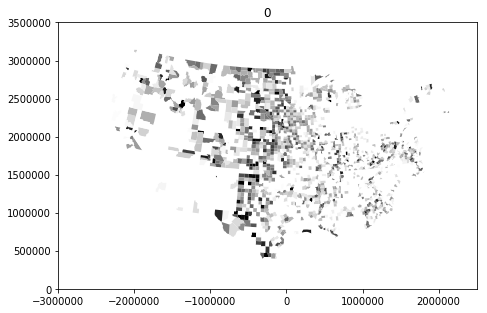

industry_code      sqrt_size cluster  \
309  3112          206.426249642  1        
196  3113          214.337976202  1        
25   3116          497.170923203  1        
295  3119          336.536574158  1        
299  3161          57.5174038931  1        
202  3222          463.07532737   1        
34   3231          788.396456229  1        
207  3255          235.581137833  1        
209  3259          265.187253774  1        
35   3261          667.535262751  1        
270  3262          280.091549903  1        
271  3312          207.121540748  1        
213  3314          213.818257624  1        
214  3315          317.39703888   1        
272  3321          310.444792845  1        
215  3322          199.536293374  1        
216  3324          261.648451546  1        
276  3326          205.285161025  1        
38   3327          558.874999651  1        
39   3328          361.139250158  1        
40   3329          471.343315217  1        
277  3335          433.795992116  1        
220  3336          207.348284623  1        
221  3339          468.943442518  1        
282  3352          167.861584389  1        
42   3353          305.496824372  1        
225  3359          294.035388868  1        
283  3361          227.610268345  1        
43   3363          733.938440921  1        
284  3365          130.695801834  1        
229  3369          167.861486045  1        
232  4235          338.322486511  1        
55   4241          377.126575539  1        
72   4453          362.21137295   1        
236  4542          202.753380727  1        
285  4811          627.997311536  1        
88   4841          955.855155969  1        
91   4854          409.303527665  1        
94   4882          120.231883861  1        
291  4889          144.704788652  1        
99   4931          690.359317126  1        
151  6231          1212.49340823  1        
172  8122          360.269485422  1        

                                               industry_title    color  
309  NAICS 3112 Grain and oilseed milling                      #001bac  
196  NAICS 3113 Sugar and confectionery product manufacturing  #001bac  
25   NAICS 3116 Animal slaughtering and processing             #001bac  
295  NAICS 3119 Other food manufacturing                       #001bac  
299  NAICS 3161 Leather and hide tanning and finishing         #001bac  
202  NAICS 3222 Converted paper product manufacturing          #001bac  
34   NAICS 3231 Printing and related support activities        #001bac  
207  NAICS 3255 Paint, coating, and adhesive manufacturing     #001bac  
209  NAICS 3259 Other chemical product and preparation mfg.    #001bac  
35   NAICS 3261 Plastics product manufacturing                 #001bac  
270  NAICS 3262 Rubber product manufacturing                   #001bac  
271  NAICS 3312 Steel product mfg. from purchased steel        #001bac  
213  NAICS 3314 Other nonferrous metal production              #001bac  
214  NAICS 3315 Foundries                                      #001bac  
272  NAICS 3321 Forging and stamping                           #001bac  
215  NAICS 3322 Cutlery and handtool manufacturing             #001bac  
216  NAICS 3324 Boiler, tank, and shipping container mfg.      #001bac  
276  NAICS 3326 Spring and wire product manufacturing          #001bac  
38   NAICS 3327 Machine shops and threaded product mfg.        #001bac  
39   NAICS 3328 Coating, engraving, and heat treating metals   #001bac  
40   NAICS 3329 Other fabricated metal product manufacturing   #001bac  
277  NAICS 3335 Metalworking machinery manufacturing           #001bac  
220  NAICS 3336 Turbine and power transmission equipment mfg.  #001bac  
221  NAICS 3339 Other general purpose machinery manufacturing  #001bac  
282  NAICS 3352 Household appliance manufacturing              #001bac  
42   NAICS 3353 Electrical equipment manufacturing             #001bac  
225  NAICS 3359 Other electrical equipment and component mfg.  #001bac  
283  NAICS 3361 Motor v

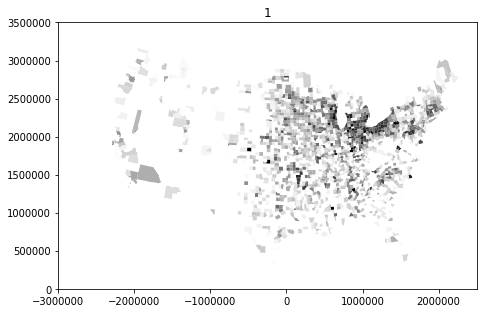

industry_code      sqrt_size cluster  \
75   4481          1016.88774539  2        
76   4482          421.90253113   2        
77   4483          408.41000253   2        
79   4512          451.683102873  2        
240  4871          84.1366557678  2        
241  4872          105.051298881  2        
97   4911          895.602042096  2        
104  5171          683.969092359  2        
110  5191          347.216241134  2        
111  5221          1311.05197526  2        
112  5222          855.654044257  2        
115  5241          1115.9968852   2        
116  5242          906.799003668  2        
118  5312          574.384371704  2        
119  5313          695.352325242  2        
124  5412          922.071588435  2        
126  5415          1070.35314071  2        
127  5416          898.202264732  2        
128  5417          722.140214426  2        
131  5511          1293.76722232  2        
136  5615          463.082576545  2        
137  5616          858.486266299  2        
141  6113          1121.21110233  2        
142  6114          268.836466051  2        
143  6116          483.679153373  2        
256  6117          230.497461074  2        
150  6221          1877.74430253  2        
154  6239          369.007208149  2        
155  6241          926.678805631  2        
259  6242          342.819941766  2        
260  6243          507.116250277  2        
159  7121          394.913929552  2        
162  7213          129.091188192  2        
165  7223          705.453965825  2        
175  8131          405.865998231  2        
176  8133          381.400223116  2        
177  8134          636.986130978  2        
178  8139          649.192109864  2        
181  9221          1240.61824904  2        
182  9231          799.906978071  2        
183  9241          482.479015073  2        
267  9251          284.901604064  2        
184  9261          710.553808113  2        
186  9281          741.015745392  2        

                                              industry_title    color  
75   NAICS 4481 Clothing stores                               #00d7ff  
76   NAICS 4482 Shoe stores                                   #00d7ff  
77   NAICS 4483 Jewelry, luggage, and leather goods stores    #00d7ff  
79   NAICS 4512 Book stores and news dealers                  #00d7ff  
240  NAICS 4871 Scenic and sightseeing transportation, land   #00d7ff  
241  NAICS 4872 Scenic and sightseeing transportation, water  #00d7ff  
97   NAICS 4911 Postal service                                #00d7ff  
104  NAICS12 5171 Wired telecommunications carriers           #00d7ff  
110  NAICS 5191 Other information services                    #00d7ff  
111  NAICS 5221 Depository credit intermediation              #00d7ff  
112  NAICS 5222 Nondepository credit intermediation           #00d7ff  
115  NAICS 5241 Insurance carriers                            #00d7ff  
116  NAICS 5242 Insurance agencies and brokerages             #00d7ff  
118  NAICS 5312 Offices of real estate agents and brokers     #00d7ff  
119  NAICS 5313 Activities related to real estate             #00d7ff  
124  NAICS 5412 Accounting and bookkeeping services           #00d7ff  
126  NAICS 5415 Computer systems design and related services  #00d7ff  
127  NAICS 5416 Management and technical consulting services  #00d7ff  
128  NAICS 5417 Scientific research and development services  #00d7ff  
131  NAICS 5511 Management of companies and enterprises       #00d7ff  
136  NAICS 5615 Travel arrangement and reservation services   #00d7ff  
137  NAICS 5616 Investigation and security services           #00d7ff  
141  NAICS 6113 Colleges and universities                     #00d7ff  
142  NAICS 6114 Business, computer and management training    #00d7ff  
143  NAICS 6116 Other schools and instruction                 #00d7ff  
256  NAICS 6117 Educational support services                  #00d7ff  
150  NAICS 6221 General medical and surgical hospitals        #00d7ff  
154  NA

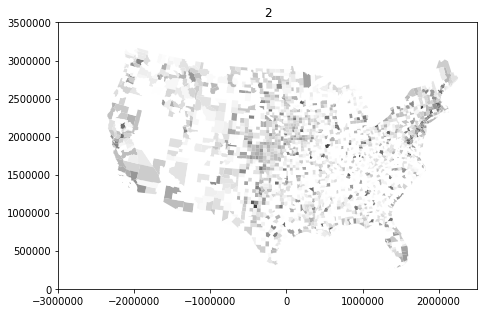

industry_code      sqrt_size cluster  \
281  3133          215.455144908  3        
200  3152          409.933408736  3        
279  3159          112.996136567  3        
30   3169          95.2502821998  3        
100  5121          556.436273695  3        
318  5174          102.641247447  3        
254  6112          511.89499764   3        
158  7115          201.694323965  3        
179  8141          688.28950312   3        

                                              industry_title    color  
281  NAICS 3133 Textile and fabric finishing mills            #00fa88  
200  NAICS 3152 Cut and sew apparel manufacturing             #00fa88  
279  NAICS 3159 Accessories and other apparel manufacturing   #00fa88  
30   NAICS 3169 Other leather product manufacturing           #00fa88  
100  NAICS 5121 Motion picture and video industries           #00fa88  
318  NAICS 5174 Satellite telecommunications                  #00fa88  
254  NAICS 6112 Junior colleges                               #00fa88  
158  NAICS 7115 Independent artists, writers, and performers  #00fa88  
179  NAICS 8141 Private households                            #00fa88

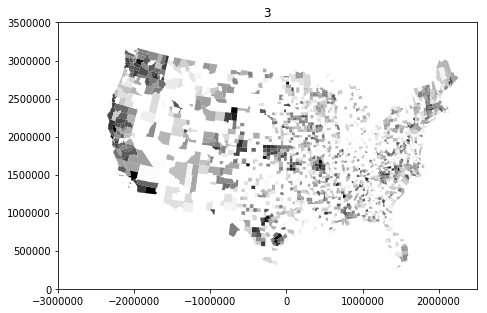

industry_code      sqrt_size cluster  \
193  2111          320.480091494  4        
194  2131          436.662772793  4        
203  3251          358.016881902  4        
41   3331          342.991294231  4        
238  4832          107.582527827  4        
317  4861          66.4550481769  4        
286  4862          126.724824841  4        

                                              industry_title    color  
193  NAICS 2111 Oil and gas extraction                        #59d200  
194  NAICS 2131 Support activities for mining                 #59d200  
203  NAICS 3251 Basic chemical manufacturing                  #59d200  
41   NAICS 3331 Ag., construction, and mining machinery mfg.  #59d200  
238  NAICS 4832 Inland water transportation                   #59d200  
317  NAICS 4861 Pipeline transportation of crude oil          #59d200  
286  NAICS 4862 Pipeline transportation of natural gas        #59d200

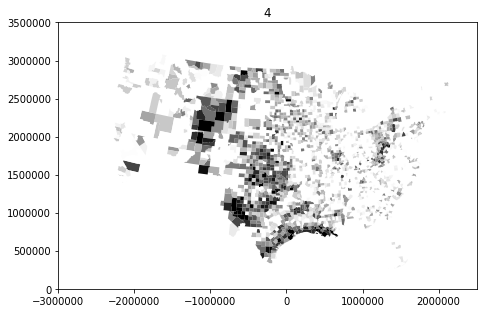

industry_code      sqrt_size cluster  \
187  1111          147.003923739  5        
188  1112          305.209564815  5        
292  1113          398.413273066  5        
3    1114          389.145245241  5        
4    1119          271.228484033  5        
5    1121          302.485024986  5        
189  1123          164.744837776  5        
319  1124          30.0631029462  5        
6    1129          109.769057549  5        
7    1132          34.1504959017  5        
9    1151          477.992906982  5        
300  3114          355.157553891  5        

                                              industry_title    color  
187  NAICS 1111 Oilseed and grain farming                     #a4ff28  
188  NAICS 1112 Vegetable and melon farming                   #a4ff28  
292  NAICS 1113 Fruit and tree nut farming                    #a4ff28  
3    NAICS 1114 Greenhouse and nursery production             #a4ff28  
4    NAICS 1119 Other crop farming                            #a4ff28  
5    NAICS 1121 Cattle ranching and farming                   #a4ff28  
189  NAICS 1123 Poultry and egg production                    #a4ff28  
319  NAICS 1124 Sheep and goat farming                        #a4ff28  
6    NAICS 1129 Other animal production                       #a4ff28  
7    NAICS 1132 Forest nursery and gathering forest products  #a4ff28  
9    NAICS 1151 Support activities for crop production        #a4ff28  
300  NAICS 3114 Fruit and vegetable preserving and specialty  #a4ff28

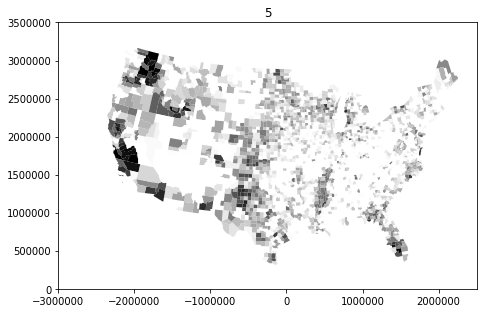

industry_code      sqrt_size cluster  \
14   2213          329.236993038  6        
195  3111          169.863538697  6        
197  3115          314.347092338  6        
198  3117          168.183468807  6        
26   3118          505.875122152  6        
269  3131          180.652140951  6        
27   3132          255.559516092  6        
28   3141          236.573467216  6        
29   3149          217.024509324  6        
289  3151          151.127178185  6        
316  3162          83.3434078131  6        
208  3256          307.575879908  6        
274  3272          243.174120606  6        
275  3274          103.069115656  6        
212  3313          165.790759585  6        
217  3325          152.533558652  6        
218  3333          304.327200123  6        
315  3343          132.437071016  6        
223  3345          612.308257731  6        
307  3346          160.156863078  6        
224  3351          198.42002449   6        
227  3364          600.306223663  6        
44   3371          527.326292295  6        
230  3372          311.615211784  6        
231  3379          182.9037602    6        
48   4232          324.616538942  6        
56   4244          815.825109069  6        
60   4249          585.449977044  6        
71   4452          478.608843187  6        
237  4812          161.737168927  6        
310  4821          10.9073602758  6        
304  4851          272.884454722  6        
92   4859          223.970897943  6        
242  4883          307.104212777  6        
95   4884          265.081605889  6        
96   4885          405.057283927  6        
106  5173          342.801537052  6        
107  5175          257.351072616  6        
313  5211          84.9124180637  6        
140  6111          2216.72675171  6        
273  6222          376.327430565  6        
152  6232          674.298418919  6        
288  7132          355.351426974  6        

                                                industry_title    color  
14   NAICS 2213 Water, sewage and other systems                 #fff000  
195  NAICS 3111 Animal food manufacturing                       #fff000  
197  NAICS 3115 Dairy product manufacturing                     #fff000  
198  NAICS 3117 Seafood product preparation and packaging       #fff000  
26   NAICS 3118 Bakeries and tortilla manufacturing             #fff000  
269  NAICS 3131 Fiber, yarn, and thread mills                   #fff000  
27   NAICS 3132 Fabric mills                                    #fff000  
28   NAICS 3141 Textile furnishings mills                       #fff000  
29   NAICS 3149 Other textile product mills                     #fff000  
289  NAICS 3151 Apparel knitting mills                          #fff000  
316  NAICS 3162 Footwear manufacturing                          #fff000  
208  NAICS 3256 Soap, cleaning compound, and toiletry mfg.      #fff000  
274  NAICS 3272 Glass and glass product manufacturing           #fff000  
275  NAICS 3274 Lime and gypsum product manufacturing           #fff000  
212  NAICS 3313 Alumina and aluminum production                 #fff000  
217  NAICS 3325 Hardware manufacturing                          #fff000  
218  NAICS 3333 Commercial and service industry machinery       #fff000  
315  NAICS 3343 Audio and video equipment manufacturing         #fff000  
223  NAICS 3345 Electronic instrument manufacturing             #fff000  
307  NAICS 3346 Magnetic media manufacturing and reproducing    #fff000  
224  NAICS 3351 Electric lighting equipment manufacturing       #fff000  
227  NAICS 3364 Aerospace product and parts manufacturing       #fff000  
44   NAICS 3371 Household and institutional furniture mfg.      #fff000  
230  NAICS 3372 Office furniture and fixtures manufacturing     #fff000  
231  NAICS 3379 Other furniture related product manufacturing   #fff000  
48   NAICS 4232 Furniture and furnishing merchant wholesalers   #fff000  
56   NAICS 4244 Grocery and related product wholesalers         #fff0

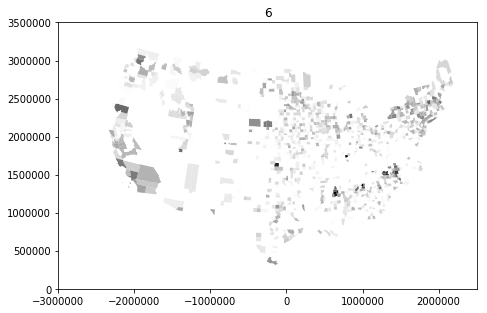

industry_code      sqrt_size cluster  \
54   4239          512.659034285  7        
234  4243          365.829325279  7        
98   4922          206.713164861  7        
245  5122          145.989643888  7        
101  5151          394.301093516  7        
102  5152          228.14780223   7        
103  5161          154.470695028  7        
250  5414          349.584424624  7        
263  7114          119.025760758  7        
174  8129          464.573071726  7        
266  8132          329.815547405  7        

                                              industry_title    color  
54   NAICS 4239 Misc. durable goods merchant wholesalers      #ffb20d  
234  NAICS 4243 Apparel and piece goods merchant wholesalers  #ffb20d  
98   NAICS 4922 Local messengers and local delivery           #ffb20d  
245  NAICS 5122 Sound recording industries                    #ffb20d  
101  NAICS 5151 Radio and television broadcasting             #ffb20d  
102  NAICS 5152 Cable and other subscription programming      #ffb20d  
103  NAICS02 5161 Internet publishing and broadcasting        #ffb20d  
250  NAICS 5414 Specialized design services                   #ffb20d  
263  NAICS 7114 Agents and managers for public figures        #ffb20d  
174  NAICS 8129 Other personal services                       #ffb20d  
266  NAICS 8132 Grantmaking and giving services               #ffb20d

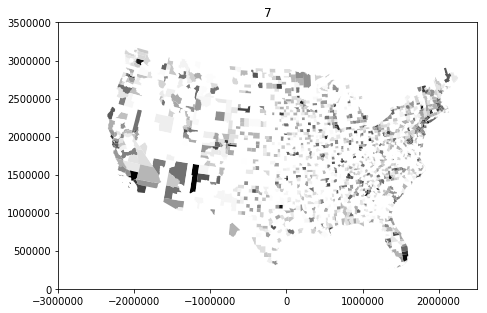

industry_code      sqrt_size cluster  \
280  1122             116.468067071  8        
301  1125             62.2257064924  8        
190  1131             105.001372732  8        
8    1133             207.350787625  8        
191  1141             73.5227961445  8        
278  1142             31.6327911873  8        
192  1152             123.81159143   8        
10   1153             106.698574685  8        
298  2121             191.455156312  8        
268  2122             119.090132271  8        
15   2361             941.439537227  8        
18   2372             277.875041144  8        
21   2381             1003.53687297  8        
22   2382             1371.26455508  8        
23   2383             964.49921298   8        
199  3121             329.480928264  8        
302  3122             68.4950424141  8        
31   3211             269.444175048  8        
201  3212             274.804662593  8        
32   3219             467.331035171  8        
33   3221             266.066018766  8        
206  3254             486.656190726  8        
210  3271             191.567321911  8        
36   3273             453.324024687  8        
303  3311             279.032295904  8        
290  3332             320.325493573  8        
293  3341             381.428478878  8        
296  3342             363.808974674  8        
222  3344             620.624782602  8        
226  3362             311.65707227   8        
228  3366             325.703695022  8        
45   3391             514.988025929  8        
47   4231             577.824579931  8        
49   4233             484.29389921   8        
50   4234             797.833939362  8        
51   4236             581.880371371  8        
233  4242             453.539129698  8        
57   4245             232.794205211  8        
235  4248             355.203065827  8        
61   4251             819.267069816  8        
62   4411             1115.76778861  8        
63   4412             392.321309827  8        
64   4413             680.53575714   8        
65   4421             528.900096748  8        
66   4422             515.637259572  8        
67   4431             726.849595421  8        
68   4441             1019.98643411  8        
69   4442             375.13241546   8        
70   4451             1549.72515225  8        
74   4471             934.035628763  8        
78   4511             658.775528213  8        
80   4521             1258.1631387   8        
82   4531             314.357074153  8        
83   4532             635.593125051  8        
84   4533             324.6788969    8        
85   4539             541.382192763  8        
86   4541             416.700704189  8        
87   4543             358.812025305  8        
311  4831             161.090623414  8        
89   4842             619.34782427   8        
90   4853             249.659870392  8        
239  4855             159.165969046  8        
297  4879             52.5442699074  8        
93   4881             397.92372877   8        
243  4921             639.13056258   8        
305  5112             480.295752472  8        
105  5172             402.004461161  8        
109  5182             493.7807611    8        
113  5223             541.554771084  8        
120  5321             439.638258212  8        
121  5322             510.095681226  8        
130  5419             716.230434556  8        
133  5612             294.590833352  8        
134  5613             1840.51559559  8        
135  5614             845.262228732  8        
138  5617             1303.45146612  8        
251  5619             512.381672699  8        
252  5621             314.947218673  8        
255  6115             310.621546711  8        
144  6211             1426.83346707  8        
145  6212             868.729704079  8        
146  6213             720.964631031  8        
257  6215             427.216491601  8        
149  6219             436.800491593  8        
153  6233   

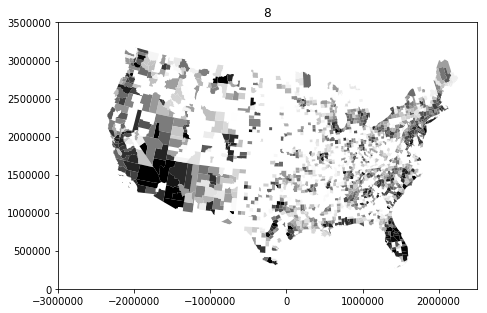

industry_code      sqrt_size cluster  \
244  5111          753.828698068  9        
114  5231          686.2150255    9        
314  5232          90.2014497311  9        
246  5239          448.707483464  9        
308  5251          177.979994485  9        
117  5311          776.329076161  9        
129  5418          658.156904179  9        
261  7111          338.015968308  9        
262  7113          259.682129231  9        

                                              industry_title    color  
244  NAICS 5111 Newspaper, book, and directory publishers     #cf18ff  
114  NAICS 5231 Securities and commodity contracts brokerage  #cf18ff  
314  NAICS 5232 Securities and commodity exchanges            #cf18ff  
246  NAICS 5239 Other financial investment activities         #cf18ff  
308  NAICS 5251 Insurance and employee benefit funds          #cf18ff  
117  NAICS 5311 Lessors of real estate                        #cf18ff  
129  NAICS 5418 Advertising, pr, and related services         #cf18ff  
261  NAICS 7111 Performing arts companies                     #cf18ff  
262  NAICS 7113 Promoters of performing arts and sports       #cf18ff

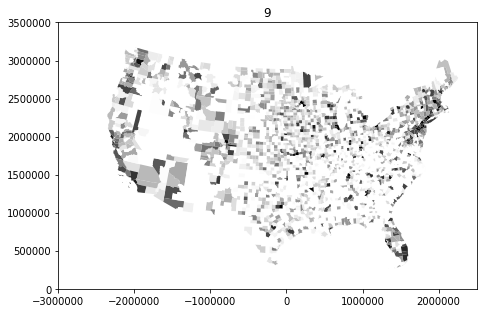

industry_code      sqrt_size cluster  \
12   2211          502.5155432    10       
13   2212          224.968342741  10       
16   2362          860.856546334  10       
17   2371          602.331432423  10       
19   2373          602.586871678  10       
24   2389          789.652801872  10       
294  3241          308.591725843  10       
204  3252          253.608782542  10       
205  3253          151.914668236  10       
37   3323          596.319000919  10       
219  3334          291.390086571  10       
52   4237          483.011003951  10       
53   4238          806.494162615  10       
58   4246          352.719861952  10       
59   4247          294.839766289  10       
81   4529          1031.36702208  10       
312  4852          130.566422223  10       
287  4869          57.8435146747  10       
306  5179          53.5510840076  10       
247  5259          146.452198578  10       
248  5323          231.456924428  10       
122  5324          316.550753664  10       
125  5413          1151.04111613  10       
253  5622          294.704616487  10       
139  5629          294.111940987  10       
148  6216          868.707472185  10       
169  8113          393.312701212  10       
185  9271          138.287185181  10       

                                             industry_title    color  
12   NAICS 2211 Power generation and supply                  #ee8df0  
13   NAICS 2212 Natural gas distribution                     #ee8df0  
16   NAICS 2362 Nonresidential building construction         #ee8df0  
17   NAICS 2371 Utility system construction                  #ee8df0  
19   NAICS 2373 Highway, street, and bridge construction     #ee8df0  
24   NAICS 2389 Other specialty trade contractors            #ee8df0  
294  NAICS 3241 Petroleum and coal products manufacturing    #ee8df0  
204  NAICS 3252 Resin, rubber, and artificial fibers mfg.    #ee8df0  
205  NAICS 3253 Agricultural chemical manufacturing          #ee8df0  
37   NAICS 3323 Architectural and structural metals mfg.     #ee8df0  
219  NAICS 3334 Hvac and commercial refrigeration equipment  #ee8df0  
52   NAICS 4237 Hardware and plumbing merchant wholesalers   #ee8df0  
53   NAICS 4238 Machinery and supply merchant wholesalers    #ee8df0  
58   NAICS 4246 Chemical merchant wholesalers                #ee8df0  
59   NAICS 4247 Petroleum merchant wholesalers               #ee8df0  
81   NAICS12 4529 Other general merchandise stores           #ee8df0  
312  NAICS 4852 Interurban and rural bus transportation      #ee8df0  
287  NAICS 4869 Other pipeline transportation                #ee8df0  
306  NAICS 5179 Other telecommunications                     #ee8df0  
247  NAICS 5259 Other investment pools and funds             #ee8df0  
248  NAICS 5323 General rental centers                       #ee8df0  
122  NAICS 5324 Machinery and equipment rental and leasing   #ee8df0  
125  NAICS 5413 Architectural and engineering services       #ee8df0  
253  NAICS 5622 Waste treatment and disposal                 #ee8df0  
139  NAICS 5629 Remediation and other waste services         #ee8df0  
148  NAICS 6216 Home health care services                    #ee8df0  
169  NAICS 8113 Commercial machinery repair and maintenance  #ee8df0  
185  NAICS 9271 Space research and technology                #ee8df0

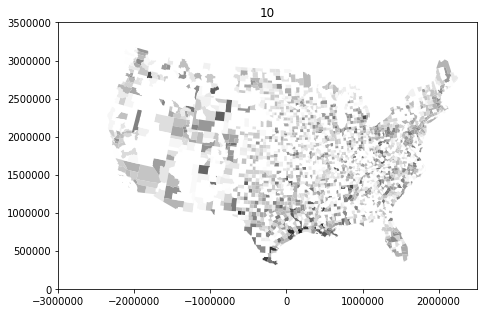

In [49]:
for col in gdf_scaled_std.iloc[:, :-1].columns:
# for col in ['0', '1', '2']:
#     display(nodes.loc[nodes.cluster == int(col)].sort_values('industry_code').sample(6, replace = True))

    display(nodes.loc[nodes.cluster == str(int(col))].sort_values('industry_code'))#.sample(6, replace = True))
    hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
    mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
    vmin = mode_level
    vmax = gdf_scaled_std[col].quantile(.99)
    
# #     norm = colors.Normalize(vmin=gdf_scaled[col].quantile(.5), vmax=gdf_scaled[col].quantile(.9))
#     norm = colors.Normalize(vmin=0, vmax=2)
#     cmap = cm.ScalarMappable(norm=norm, cmap=cm.gray_r)
#     ec = [cmap.to_rgba(cl) for cl in gdf_scaled[col].values]
    
#     ax = gdf_scaled_std.to_crs(fancy_crs).plot(column = col, color = 'None',  edgecolor=ec,
#                          linewidth = .5, figsize = (7.5, 6))
    

#     vmin = gdf_scaled_std[col].quantile(.05)
#     vmax = gdf_scaled_std[col].quantile(.95)
    
    ax = gdf_scaled_std.to_crs(fancy_crs).plot(column = col, cmap=plt.cm.gray_r, 
                         vmin = vmin, vmax = vmax, 
                         linewidth = 0, figsize = (7.5, 6))

    ax.set_title(col)
    ax.set_xlim(-3e6, 2.5e6)
    ax.set_ylim(0, 3.5e6)
#     ax.set_xlim(-1.5e7, -.7e7)
#     ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#     ax.axis('off')
    plt.show()

In [50]:
## Network, choosing key clusters

In [51]:
nodes_['color_edit'] = nodes_['color']
nodes_.loc[nodes_.cluster.isin([2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]), 'color_edit'] = '#b3b3b3'

nodes_.loc[~nodes_.cluster.isin([2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17])][['cluster', 'color']].drop_duplicates()

cluster    color
4   1        #001bac
6   3        #00fa88
25  4        #59d200
72  0        #d3d3d3

In [52]:
name = 'clusters'; color = 'color_edit';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

In [53]:
# for col in gdf_scaled_std.iloc[:, :-1].columns:
#     plt.hist(gdf_scaled_std[col], np.arange(-3, 5, .25))
    
#     hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
#     mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
#     plt.axvline(mode_level, c = 'k')
#     plt.axvline(gdf_scaled_std[col].quantile(.99), c = 'k')
#     plt.show()

In [54]:
# county_fips = gdf_scaled_std.index
# # df = gdf_scaled_std.sort_index()

# # for col in gdf_scaled_std.iloc[:, :-1].columns:
# for col in ['2']:
#     fig, ax = plt.subplots(1, figsize = (5 * (3 + 2.5)/3.5, 5))
    
#     hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
#     mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
#     vmin = mode_level
#     vmax = gdf_scaled_std[col].quantile(.99)
    
#     for fips in county_fips:
#         df = gdf_scaled_std.loc[[fips]]
    
    
#     #     display(nodes.loc[nodes.cluster == int(col)].sort_values('industry_code'))

#     # #     norm = colors.Normalize(vmin=gdf_scaled[col].quantile(.5), vmax=gdf_scaled[col].quantile(.9))



#     #     cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.gray_r)
#         cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.jet)
# #         ec = [cmap.to_rgba(cl) for cl in df[col].values]
#         ec = cmap.to_rgba(df[col]) # for individual county

#         df.to_crs(fancy_crs).plot(column = col, color = 'None',  edgecolor=ec,
#                              linewidth = 1, ax = ax, alpha = .5)

#     ax.set_title(col)
#     ax.set_xlim(-3e6, 2.5e6)
#     ax.set_ylim(0, 3.5e6)

# # # wyoming
# #     ax.set_xlim(-1.3e6, -.6e6)
# #     ax.set_ylim(2e6, 2.6e6)

# #     ax.set_xlim(-1.5e7, -.7e7)
# #     ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
# #     ax.axis('off')
#     plt.show()